# ChemPy

ChemPy is a useful Python libray for physical, inorganic, and analytical chemistry. It comes with the following capabilities:

- Numerical integration routines for chemical kinetics (ODE solver front-end)
- Integrated rate expressions (and convenience fitting routines)
- Solver for equilibria (including multiphase systems)
- Relations in physical chemistry:
    - Debye-Hückel expressions
    - Arrhenius & Eyring equation
    - Einstein-Smoluchowski equation
- Properties (pure python implementations from the literature)
    - water density as function of temperature
    - water permittivity as function of temperature and pressure
    - water diffusivity as function of temperature
    - water viscosity as function of temperature
    - sulfuric acid density as function of temperature & weight fraction H₂SO₄

There is ongoing maintenance and development of the library, which is encouraging!

## Periodic Table of Elements

Before running too far into the capabilities of ChemPy, let's make sure we can do the basics. Python has a [library specifically for pulling elements from the periodic table](https://pypi.org/project/periodictable/):

In [1]:
import chempy
import periodictable
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from collections import defaultdict
from chempy.kinetics.ode import get_odesys

<img src='https://pubchem.ncbi.nlm.nih.gov/periodic-table/Periodic_Table.png' alt='periodic_table' width="700"/>

In [5]:
try:
    # get an element from the notebook user
    atomic_no = int(input("Enter the Atomic Number of the Element: "))
    element = periodictable.elements[atomic_no]
    # print properties of the selected element.
    print("Atomic Number:", element.number)
    print("Symbol:", element.symbol)
    print("Name:", element.name)
    print("Atomic Mass:", element.mass)
    print("Density:", element.density)
     
except ValueError:
    # if a non-int is typed in the user input
    print("Please enter a valid atomic number as an integer.")
     
except KeyError:
    # if the periodic table does not contain the user input's int
    print("The entered atomic number does not exist in the periodic table.")

Enter the Atomic Number of the Element:  17


Atomic Number: 17
Symbol: Cl
Name: chlorine
Atomic Mass: 35.453
Density: 1.56


## Parsing Formulae

It is great that we can establish our footing by analyzing the properties of elements on the period table, as a natural next step, ChemPy enables researchers to parse through chemical formulae. Below will explore the chemical formula for [Novocaine](https://www.drugs.com/novocain.html#:~:text=Novocain%20is%20a%20local%20anesthetic,other%20medical%20and%20dental%20procedures.), a molecule [first synthesized in 1905](https://www.invent.org/inductees/alfred-einhorn#:~:text=German%20chemist%20Alfred%20Einhorn%20invented,most%20commonly%20used%20local%20anesthetic.) for use during amputations and other surgeries:

In [3]:
novocaine = chempy.Substance.from_formula('C13H20N2O2')
print(novocaine.unicode_name)

C₁₃H₂₀N₂O₂


#### LaTeX and HTML Outputs 

ChemPy ***Substance*** instances can quickly be converted quickly into LaTeX or HTML outputs of it's formula via built-in library functions.

For example, take **Novocaine's handwritten formulas**:

- $C_{13}H_{20}N_{2}O_{2}$
- <p>C<sub>13</sub>H<sub>20</sub>N<sub>2</sub>O<sub>2</sub></p>

ChemPy is able to produce the result for a given "view" dynamically (based on the value of the *Substance* in question):

In [4]:
print('latex: ', novocaine.latex_name + '\nhtml: ' + novocaine.html_name)

latex:  C_{13}H_{20}N_{2}O_{2}
html: C<sub>13</sub>H<sub>20</sub>N<sub>2</sub>O<sub>2</sub>


#### Substance Properties

The *Substance* object also stores basic properties of the substance, such as mass:

In [6]:
print('%.3f' % novocaine.mass)

236.315


## Stoichiometry 

Originally derived from the Greek words *stoicheion* ("element") and *metron* ("measure"), this classic science is translated into ChemPy, where stoichiometric relationships are coded to balance chemical equations by determining the amounts of substances to be consumed and produced in chemical reactions. 

Below is a straightforward example that ChemPy provides, but you can use this process to think through techniques for solving [retrosynthesis tasks](https://www.youtube.com/watch?v=wDWH6H7KK54) when [creating target molecules](https://en.wikipedia.org/wiki/Retrosynthetic_analysis).

In [7]:
# main reaction for NASA's booster rockets:
reac, prod = chempy.balance_stoichiometry({'NH4ClO4', 'Al'}, {'Al2O3', 'HCl', 'H2O', 'N2'})

In [8]:
pprint(dict(reac))

{'Al': 10, 'NH4ClO4': 6}


In [9]:
pprint(dict(prod))

{'Al2O3': 5, 'H2O': 9, 'HCl': 6, 'N2': 3}


In [10]:
for fractions in map(chempy.mass_fractions, [reac, prod]):
    pprint({k: '{0:.3g} wt%'.format(v*100) for k, v in fractions.items()})

{'Al': '27.7 wt%', 'NH4ClO4': '72.3 wt%'}
{'Al2O3': '52.3 wt%', 'H2O': '16.6 wt%', 'HCl': '22.4 wt%', 'N2': '8.62 wt%'}


### Balancing Custom Grammars

ChemPy can balance reactions where the reacting substances are more complex or abstract. Using a custom grammar, below is a slightly sillier example than the one ChemPy provides - [how to make waffles](https://www.youtube.com/watch?v=a8jzvh5Wb00) without any partially used packages:

In [11]:
substances = {s.name: s for s in [
    chempy.Substance('waffle', composition=dict(eggs=1, spoons_of_flour=2, cups_of_milk=1)),
    chempy.Substance('eggs_6pack', composition=dict(eggs=6)),
    chempy.Substance('milk_carton', composition=dict(cups_of_milk=4)),
    chempy.Substance('flour_bag', composition=dict(spoons_of_flour=60)),
]}

In [12]:
pprint([dict(_) for _ in chempy.balance_stoichiometry({'eggs_6pack', 'milk_carton', 'flour_bag'}, {'waffle'}, substances=substances)])

[{'eggs_6pack': 10, 'flour_bag': 2, 'milk_carton': 15}, {'waffle': 60}]


## Chemical Kinetics

ChemPy has built-in functions to study [chemical kinetics](https://en.wikipedia.org/wiki/Chemical_kinetics), or "reaction kinetics". This is a branch of physical chemistry focused on understanding the ***rates*** of chemical reactions, rather than the direction (Thermodynamics). This helps with planning target compound synthesis.

In [13]:
rsys = chempy.ReactionSystem.from_string(
    """
    2 Fe+2 + H2O2 -> 2 Fe+3 + 2 OH-; 42 
    2 Fe+3 + H2O2 -> 2 Fe+2 + O2 + 2 H+; 17 
    H+ + OH- -> H2O; 1e10 
    H2O -> H+ + OH-; 1e-4
    """
)

Chemical kinetics is used to develop mathematical models that describe characteristics of a chemical reaction. Taking into account how experimental conditions may influence the speed and yield information for a chemical reaction's mechanism and transition states.

In [14]:
odesys, extra = get_odesys(rsys)

In [15]:
tout = sorted(np.concatenate((np.linspace(0, 23), np.logspace(-8, 1))))
c0 = defaultdict(float, {'Fe+2': 0.05, 'H2O2': 0.1, 'H2O': 1.0, 'H+': 1e-2, 'OH-': 1e-12})
result = odesys.integrate(tout, c0, atol=1e-12, rtol=1e-14)

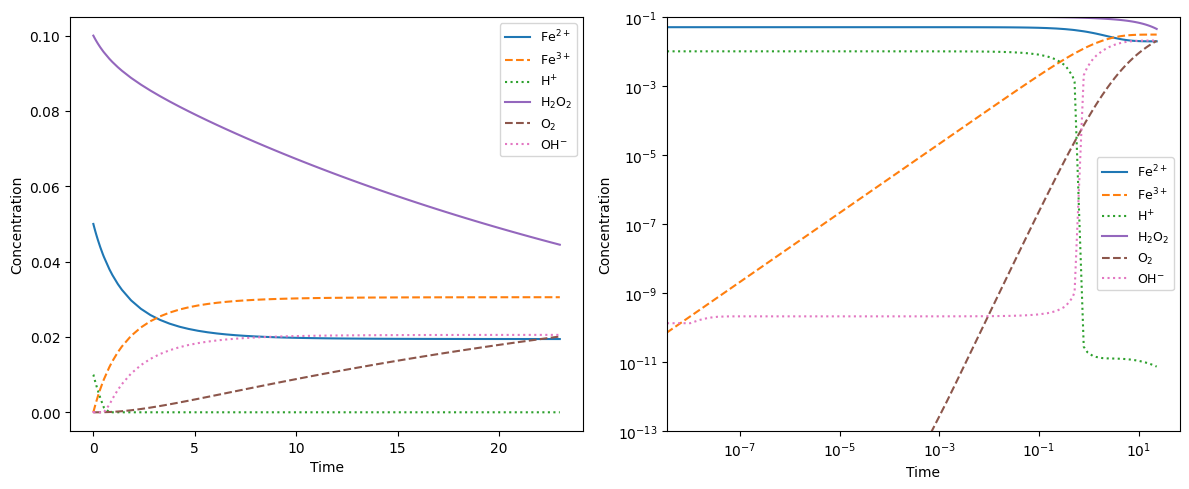

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    _ = result.plot(names=[k for k in rsys.substances if k != 'H2O'], ax=ax)
    _ = ax.legend(loc='best', prop={'size': 9})
    _ = ax.set_xlabel('Time')
    _ = ax.set_ylabel('Concentration')
_ = axes[1].set_ylim([1e-13, 1e-1])
_ = axes[1].set_xscale('log')
_ = axes[1].set_yscale('log')
_ = fig.tight_layout()
_ = fig.savefig('examples/kinetics.png', dpi=72)

As systems become more automated for synthesizing molecular compounds, research projects are able to allocate more time studying unmet needs and experiments are able to tolerate increased levels of risk profile (since they are able to be simulated in a computer without material loss as a concern).